In [1]:
import pandas as pd

df = pd.read_csv('preprocessed_data.csv')

In [2]:
df.shape

(826701, 8)

In [3]:
df.head(5)

,matchid,innings,over,ball,runs,wickets,chasing_team_won,total_chasing
0,1001349,1,0,1,0,0,1.0,NaN
1,1001349,1,0,2,0,0,1.0,NaN
2,1001349,1,0,3,1,0,1.0,NaN
3,1001349,1,0,4,3,0,1.0,NaN
4,1001349,1,0,5,3,0,1.0,NaN


In [ ]:
# Remove ties
df = df.loc[df['chasing_team_won'].notna(), :] 

In [5]:
df.shape

(825451, 8)

In [6]:
features = [
    'innings',
    'ball',
    'runs',
    'wickets',
    'total_chasing'
]

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

groups = df['matchid']

# We want all rows from a particular match to go in the same dataset (train vs. test)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx, test_idx = next(gss.split(df, groups=groups))

df_train = df.iloc[train_idx]
df_test = df.iloc[test_idx]

In [8]:
df_train.shape

(659861, 8)

In [9]:
df_test.shape

(165590, 8)

In [10]:
X_train, y_train = df_train[features], df_train['chasing_team_won']
X_test, y_test = df_test[features], df_test['chasing_team_won']

In [11]:
import catboost as cb

model = cb.CatBoostClassifier(
    random_state=42
)

In [12]:
model.fit(
    X=X_train,
    y=y_train,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [13]:
model.save_model('model.cbm')

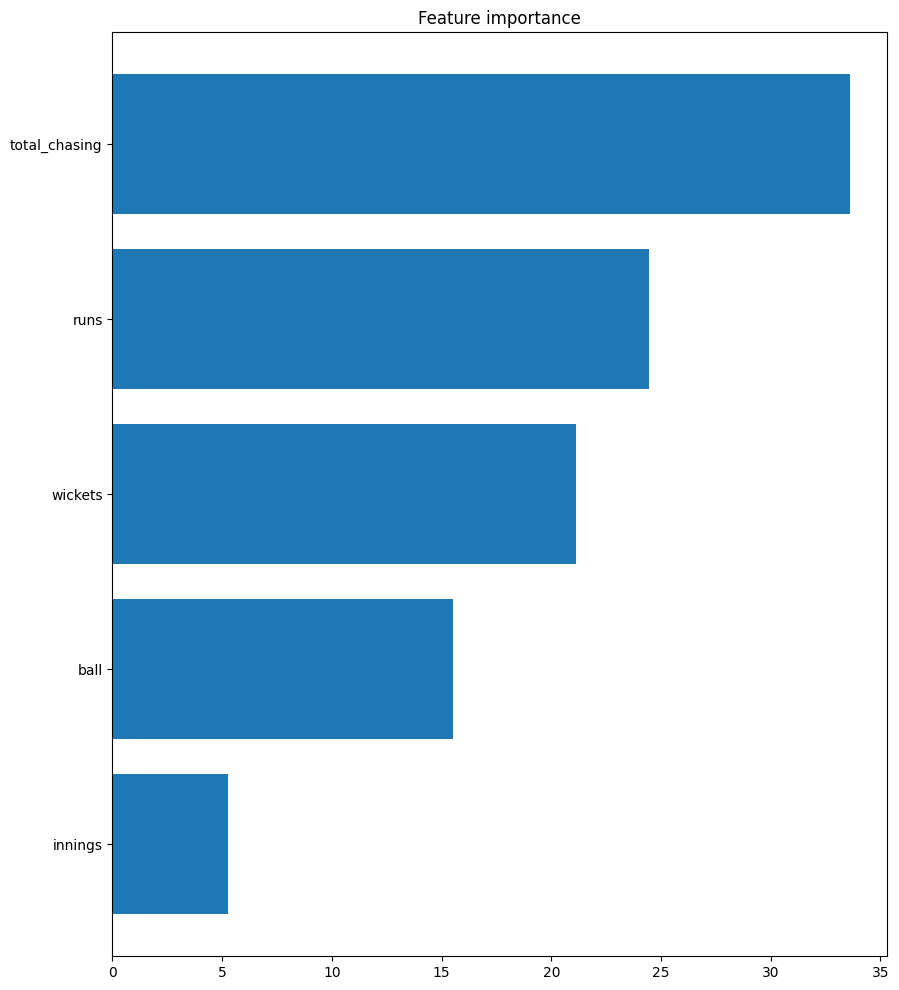

In [14]:
import matplotlib.pyplot as plt
import numpy as np

feature_importances = model.get_feature_importance()
features_array = np.array(features)

sorted_idx = np.argsort(feature_importances).astype(int)
y_ticks = range(len(features))

plt.figure(figsize=(10, 12))
plt.barh(y_ticks, feature_importances[sorted_idx])
plt.yticks(y_ticks, features_array[sorted_idx])
plt.title('Feature importance')
plt.show()

In [15]:
feature_statistics_plot = model.calc_feature_statistics(
    data=X_train,
    target=y_train,
    prediction_type='Probability',
    plot=False,
    plot_file='feature_statistics.html'
)

In [ ]:
# Represents probability that the chasing team will win
train_preds_proba = model.predict_proba(X_train)[:, 1]
test_preds_proba = model.predict_proba(X_test)[:, 1]

In [17]:
from sklearn.metrics import roc_auc_score

train_auc = roc_auc_score(y_train, train_preds_proba)
test_auc = roc_auc_score(y_test, test_preds_proba)

print(f'Train ROC AUC: {train_auc:.2f}')
print(f'Test ROC AUC: {test_auc:.2f}')

Train ROC AUC: 0.86
Test ROC AUC: 0.83


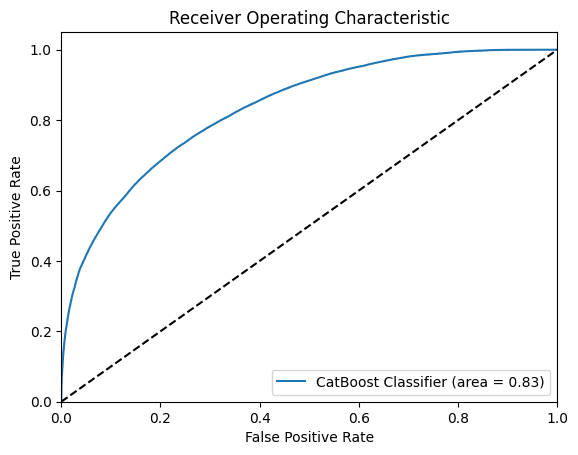

In [18]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, test_preds_proba)

plt.figure()
plt.plot(fpr, tpr, label='CatBoost Classifier (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Use 0.5 as threshold to move from probability predictions to outcome predictions
train_preds = (train_preds_proba >= 0.5).astype(int)
test_preds = (test_preds_proba >= 0.5).astype(int)

In [20]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print(f'Train Accuracy: {train_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

Train Accuracy: 0.76
Test Accuracy: 0.75


In [ ]:
# Create column that tracks number of balls remaining match (1 to 240)
df_test_sorted = df_test.sort_values(by=['matchid', 'innings', 'ball']).reset_index(drop=True)
df_test_sorted['balls_remaining'] = np.where(
    df_test_sorted['innings'] == 1,
    240 - df_test_sorted['ball'] + 1,
    np.where(
        df_test_sorted['innings'] == 2,
        120 - df_test_sorted['ball'] + 1,
        np.nan
    )
).astype(int)

In [22]:
# Compute accuracy at each unique value of balls remaining (1 to 240)
progress_points = sorted(df_test_sorted['balls_remaining'].unique(), reverse=True)

progress = []
accuracy_scores = []

for point in progress_points:

    df_progress = df_test_sorted[df_test_sorted['balls_remaining'] >= point]
    df_latest = df_progress.groupby('matchid').last().reset_index()
    
    X_progress = df_latest[features]
    y_progress = df_latest['chasing_team_won']
    
    y_pred_proba = model.predict_proba(X_progress)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    acc = accuracy_score(y_progress, y_pred)
    
    progress.append(point)
    accuracy_scores.append(acc)

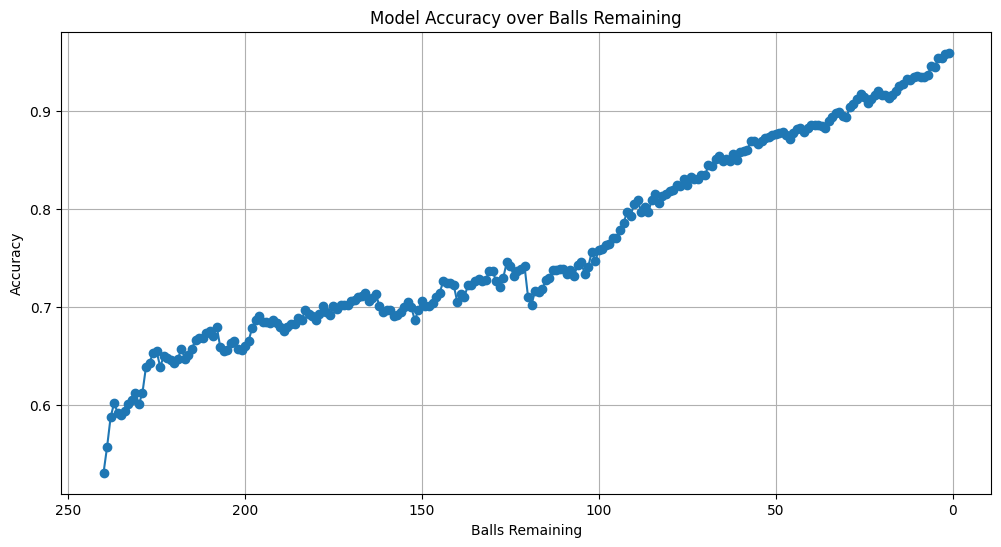

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(progress, accuracy_scores, marker='o')
plt.xlabel('Balls Remaining')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Balls Remaining')
plt.gca().invert_xaxis()  # Invert x-axis to show progress from start to end
plt.grid(True)
plt.show()
